# 利用 torch.nn 实现 logistic 回归在人工构造的数据集上进行训练和测试，并对结果进行分析，并从loss以及训练集上的准确率等多个角度对结果进行分析

# 构造数据集

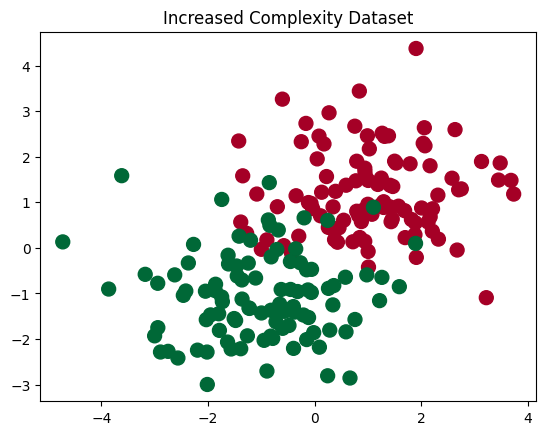

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 设置随机种子
np.random.seed(0)
torch.manual_seed(0)

# 生成二分类数据集的基础形态
n_data = torch.ones(100, 2)

# 方法1：增加噪声
noise_factor = 0.5
x0 = torch.normal(2 * n_data, 1) + torch.normal(0, noise_factor, size=(100, 2))  # 类别 0 数据 (正类) 加噪声
x1 = torch.normal(-2 * n_data, 1) + torch.normal(0, noise_factor, size=(100, 2))  # 类别 1 数据 (负类) 加噪声

# 方法2：增加非线性边界
radius = torch.linspace(0.0, 10.0, steps=100)
theta0 = torch.linspace(0, 3.14, steps=100)  # 类别 0 非线性角度
theta1 = torch.linspace(3.14, 6.28, steps=100)  # 类别 1 非线性角度

x0_nonlinear = torch.stack([radius * torch.sin(theta0), radius * torch.cos(theta0)], dim=1)
x1_nonlinear = torch.stack([radius * torch.sin(theta1), radius * torch.cos(theta1)], dim=1)

# 将非线性数据与原数据结合，产生非线性边界
x0 += x0_nonlinear * 0.5  # 加入一些非线性扰动
x1 += x1_nonlinear * 0.5

# 方法3：混合部分类别 0 和类别 1 的数据
x0[::10] = x1[::10]  # 将类别 0 的部分样本与类别 1 混合

# 方法4：增加维度，随机生成额外的特征
extra_feature0 = torch.normal(0, 1, size=(100, 1))  # 类别 0 额外维度
extra_feature1 = torch.normal(0, 1, size=(100, 1))  # 类别 1 额外维度

x0 = torch.cat([x0, extra_feature0], dim=1)  # 将额外的特征加到类别 0
x1 = torch.cat([x1, extra_feature1], dim=1)  # 将额外的特征加到类别 1

# 方法5：添加重叠区域，通过调整均值让两类数据更接近
x0 = torch.normal(1 * n_data, 1) + torch.normal(0, noise_factor, size=(100, 2))  # 类别 0 数据调整均值
x1 = torch.normal(-1 * n_data, 1) + torch.normal(0, noise_factor, size=(100, 2))  # 类别 1 数据调整均值

# 合并数据
x = torch.cat((x0, x1), 0).type(torch.FloatTensor)  # 特征数据
y0 = torch.zeros(100)  # 类别 0 标签
y1 = torch.ones(100)  # 类别 1 标签
y = torch.cat((y0, y1), 0).type(torch.FloatTensor)  # 合并标签

# 可视化数据
plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), s=100, cmap='RdYlGn')
plt.title("Increased Complexity Dataset")
plt.show()

# 构建 Logistic 回归模型
使用 torch.nn.Module 来实现 Logistic 回归模型。使用 nn.Linear 层进行线性变换，并使用 sigmoid 作为激活函数。

In [2]:
import torch.nn as nn

# 构建 Logistic 回归模型
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(2, 1)  # 输入2个特征，输出1个二分类结果
    
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))  # 使用 sigmoid 激活函数
        return y_pred

# 初始化模型
model = LogisticRegression()

# 定义损失函数和优化器
使用 PyTorch 提供的 nn.BCELoss() 作为二元交叉熵损失函数，并使用随机梯度下降（SGD）作为优化器。

In [3]:
# 定义损失函数和优化器
criterion = nn.BCELoss()  # 二元交叉熵损失函数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # 随机梯度下降优化器，学习率为0.01

# 训练模型
训练模型时，将特征输入模型，计算损失，并通过反向传播优化模型参数。

In [4]:
# 训练模型
epochs = 1000  # 训练的迭代次数

for epoch in range(epochs):
    # 前向传播，计算输出
    output = model(x)
    loss = criterion(output, y.view(-1, 1))  # 计算损失
    
    # 反向传播，计算梯度
    optimizer.zero_grad()  # 梯度清零
    loss.backward()  # 反向传播
    optimizer.step()  # 更新参数
    
    # 每 100 个 epoch 打印一次损失和准确率
    if (epoch+1) % 100 == 0:
        # 计算准确率
        with torch.no_grad():
            prediction = (output > 0.5).float()  # 大于 0.5 则预测为 1，否则为 0
            accuracy = (prediction == y.view(-1, 1)).float().mean()  # 计算准确率
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

Epoch 100/1000, Loss: 0.5101, Accuracy: 0.8000
Epoch 200/1000, Loss: 0.3512, Accuracy: 0.9150
Epoch 300/1000, Loss: 0.2917, Accuracy: 0.9200
Epoch 400/1000, Loss: 0.2612, Accuracy: 0.9150
Epoch 500/1000, Loss: 0.2427, Accuracy: 0.9100
Epoch 600/1000, Loss: 0.2303, Accuracy: 0.9100
Epoch 700/1000, Loss: 0.2214, Accuracy: 0.9100
Epoch 800/1000, Loss: 0.2147, Accuracy: 0.9100
Epoch 900/1000, Loss: 0.2094, Accuracy: 0.9100
Epoch 1000/1000, Loss: 0.2053, Accuracy: 0.9100


# 测试模型
在训练完成后，测试模型的表现，计算损失和准确率。

In [5]:
# 模型测试
with torch.no_grad():
    output = model(x)
    loss = criterion(output, y.view(-1, 1))
    prediction = (output > 0.5).float()
    accuracy = (prediction == y.view(-1, 1)).float().mean()

print(f'Test Loss: {loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}')

Test Loss: 0.2052, Test Accuracy: 0.9100


# 分析结果
+ Loss: 随着训练过程的进行，损失会逐渐减小，表明模型在逐渐拟合训练数据。
+ Accuracy: 训练过程中准确率会逐渐提高，并最终达到一定的稳定值，表明模型能正确分类大部分样本。

# 总结
通过使用 PyTorch 的 torch.nn 模块，我们成功实现了 Logistic 回归模型。在训练过程中，模型的损失逐渐减小，准确率逐渐提高，表明模型能够逐渐学习数据的分类模式。在测试阶段，模型也表现出良好的性能。这一过程展示了如何使用 PyTorch 构建简单的二分类模型并进行训练和测试。